### Single-Phase Flow Simulator (2D - Compressible flow / FIM ) - Revised 06/07/2020
* **Fully Implicit Method : Newton-Raphson**
* **Developed by Kittipong Limchuchua**

*This is a 2D simulator for CH8 Project in Ertekin textbook (Number of layer = 1, so it is converted to 2D problem)*

In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import xlrd

workbook_name = 'CH8_reservoir prop (2D gas).xlsx'
#importing data box
Nx = 12
Ny = 9
Nz = 1 #This is 2D problem (Nz = 1)
t = 5
dt = 0.5 #days

# reservoir properties
pi = 7750
p_ref = 14.7
cr = 0 #5e-8
calpha = 5.6146
cbeta = 1.127e-3
Z_datum = 9300

#PVT properties
p_sc = 14.7
T_sc = 520
Mw_air = 28.97
R_const = 10.732
Mw_gas = 22.836
SGg = Mw_gas/Mw_air
T_res = 190 + 460
Rconst = 10.732

#array matrix for reservoir properties
dx = np.zeros((Nz,Ny,Nx))
dy = np.zeros((Nz,Ny,Nx))
kx = np.zeros((Nz,Ny,Nx))
ky = np.zeros((Nz,Ny,Nx))
kz = np.zeros((Nz,Ny,Nx))
Ax = np.zeros((Nz,Ny,Nx))
Ay = np.zeros((Nz,Ny,Nx))
Az = np.zeros((Nz,Ny,Nx))
phi = np.zeros((Nz,Ny,Nx))
phi_ref = np.zeros((Nz,Ny,Nx))
h = np.zeros((Nz,Ny,Nx))
top = np.zeros((Nz,Ny,Nx))
bottom = np.zeros((Nz,Ny,Nx))
middle = np.zeros((Nz,Ny,Nx))
null = np.zeros((Nz,Ny,Nx))
null_im = []

p = np.zeros((Nz,Ny,Nx))
p_new = np.zeros((Nz,Ny,Nx))
p_inner = np.zeros((Nz,Ny,Nx))
qgsc = np.zeros((Nz,Ny,Nx))
pwf = np.zeros((Nz,Ny,Nx))
Jw = np.zeros((Nz,Ny,Nx))
Jw_switch = np.zeros((Nz,Ny,Nx))

In [2]:
# Gas property Generator
def zg(P,T,SGg):
    
    P_pr = P/P_critical(SGg)
    T_pr = T/T_critical(SGg)
    
    #P_pr = P/738.44
    #T_pr = T/418.38
    
    A1 = 0.3265         
    A2 = -1.07          
    A3 = -0.5339        
    A4 = 0.01569        
    A5 = -0.05165        
    A6 = 0.5475
    A7 = -0.7361       
    A8 = 0.1844         
    A9 = 0.1056         
    A10 = 0.6134        
    A11 = 0.721
        
    C1 = A1 + A2 / T_pr + A3 / (T_pr * T_pr * T_pr) + A4 / (T_pr * T_pr * T_pr * T_pr) + A5 / (T_pr * T_pr * T_pr * T_pr * T_pr)
    C2 = A6 + A7 / T_pr + A8 / (T_pr * T_pr)
    C3 = A9 * (A7 / T_pr + A8 / (T_pr * T_pr))

    Ze = 1
    for i in range(0,100):
        rho_pr = 0.27 * (P_pr / (Ze * T_pr))
        C4 = A11 * rho_pr * rho_pr
        Zc = 1 + C1 * rho_pr + C2 * rho_pr * rho_pr - C3 * (rho_pr * rho_pr * rho_pr * rho_pr * rho_pr) + A10 * (1 + C4) * (rho_pr * rho_pr / (T_pr * T_pr * T_pr)) * np.exp(-C4)
        if (np.abs(Ze - Zc) < 0.001):
            break
        else:
            fz = Ze - Zc
            dfdZ = 1 + (rho_pr * rho_pr / Ze) * (C1 / rho_pr + 2 * C2 - 5 * C3 * (rho_pr * rho_pr * rho_pr) + 2 * A10 * np.exp(-C4) * (1 + C4 - C4 * C4) / (T_pr * T_pr * T_pr))
            Ze = Ze - fz / dfdZ
    
    return Zc


def T_critical(SGg):  #Sutton
    return 169.2 + 349.5 * SGg - 74 * SGg * SGg 
def P_critical(SGg): #Sutton
    return 756.8 - 131 * SGg - 3.6 * SGg**2
def T_reduced(T,SGg): #T in Rankine
    return T/T_critical(SGg)
def P_reduced(P,SGg): #T in Rankine
    return P/P_critical(SGg)

def cal_rhog(P,T,SGg):
    Mwg = SGg * Mw_air
    z = zg(P,T,SGg)
    return P*Mwg/z/R_const/T

def cal_viscg(P,T,SGg):
    z = zg(P,T,SGg)
    gasdensPT = cal_rhog(P,T,SGg)
    gasdensPT = gasdensPT * 1000 / (2.20462262184878 * ((0.3048 * 100) ** 3)) 
    Mwg = SGg * Mw_air
    XK = (9.379 + 0.01607 * Mwg) * ((T ** 1.5) / (209.2 + 19.26 * Mwg + T))
    X = 3.448 + 986.4 / T + 0.01009 * Mwg
    Y = 2.447 - 0.2224 * X
    return (XK / 10000) * np.exp(X * (gasdensPT ** Y))

def cal_cg(P,T,SGg):
    dP = 1
    z_left2 = zg(P-2*dP,T,SGg)
    z_left1 = zg(P-dP,T,SGg)
    z_cen = zg(P,T,SGg)
    z_right1 = zg(P+dP,T,SGg)
    z_right2 = zg(P+2*dP,T,SGg)
    dzdP = (z_right1-z_left1)/2/dP
    #dzdP = (-z_left2+8*z_left1-8*z_right1+z_right2)/12/dP
    return 1/P-1/z_cen*dzdP
    
def cal_Bg(P,T,SGg):
    Bg = p_sc/T_sc*zg(P,T,SGg)*T/P
    return Bg/5.6146

#for testing purpose
#print(zg(5000,T_res,SGg))
#print(cal_Bg(5000,T_res,SGg))
#print(cal_viscg(5000,T_res,SGg))
#print(cal_rhog(5000,T_res,SGg))
#print(cal_rhog(14.7,520,SGg))
#print(cal_cg(5000,T_res,SGg))

In [3]:
#important function
def cal_phi(p,p_ref,phi_ref,cr):
    return phi_ref*(1+cr*(p-p_ref))

def id_tran(iz,iy,ix):
    return ix + Nx*iy + Nx*Ny*iz

def Jw_cal(dx,dy,kx,ky,h,viscg,Bg,rw,skin):
    req = 0.28*np.sqrt(np.sqrt(ky/kx)*dx**2+np.sqrt(kx/ky)*dy**2)/((ky/kx)**0.25+(kx/ky)**0.25)
    return 2*np.pi*cbeta*np.sqrt(kx*ky)*h/viscg/Bg/(np.log(req/rw)+skin)

def p_res_average_cal(p):
    # MBE check
    p_res_num = 0
    p_res_deno = 0
    for ix in range (0,Nx):
        for iy in range(0,Ny):
            if (null[iz,iy,ix] != 0):
                p_res_num += dx[iz,iy,ix]*dy[iz,iy,ix]*h[iz,iy,ix]*cal_phi(p[iz,iy,ix],p_ref,phi_ref[iz,iy,ix],cr)*p[iz,iy,ix]
                p_res_deno += dx[iz,iy,ix]*dy[iz,iy,ix]*h[iz,iy,ix]*cal_phi(p[iz,iy,ix],p_ref,phi_ref[iz,iy,ix],cr)
    return p_res_num/p_res_deno

#pressure initialization (gravitational equilibrium)
def pressure_initializer(Z,p_datum,Z_datum):
    p_mid = p_datum
    dp_dZ_mid =  cal_rhog(p_mid,T_res,SGg)/144
    p_cal = p_datum + dp_dZ_mid*(Z-Z_datum)
    p_mid = (p_datum+p_cal)/2

    while True:
        dp_dZ_mid =  cal_rhog(p_mid,T_res,SGg)/144
        p_cal_new = p_datum + dp_dZ_mid*(Z-Z_datum)
        if abs(p_cal_new-p_cal) < 0.0001:
            break
        p_cal = p_cal_new
        p_mid = (p_datum+p_cal_new)/2
    return p_cal_new

#print(pressure_initializer(9270,7750,9300))

In [4]:
#initialization
res_Excel = xlrd.open_workbook(workbook_name)

for ix in range (0,Nx):
    for iy in range(0,Ny):       
        for iz in range(0,Nz):
            dx[:,iy,ix] = res_Excel.sheet_by_name('dx').cell(iy,ix).value
            dy[:,iy,ix] = res_Excel.sheet_by_name('dy').cell(iy,ix).value

            if iz == 0:

                kx[iz,iy,ix] = res_Excel.sheet_by_name('kx1').cell(iy,ix).value
                ky[iz,iy,ix] = res_Excel.sheet_by_name('ky1').cell(iy,ix).value
                kz[iz,iy,ix] = res_Excel.sheet_by_name('kz1').cell(iy,ix).value
                phi[iz,iy,ix] = res_Excel.sheet_by_name('phi1').cell(iy,ix).value
                phi_ref[iz,iy,ix] = res_Excel.sheet_by_name('phi1').cell(iy,ix).value
                top[iz,iy,ix] = res_Excel.sheet_by_name('T1').cell(iy,ix).value
                bottom[iz,iy,ix] = res_Excel.sheet_by_name('B1').cell(iy,ix).value
                null[iz,iy,ix] = res_Excel.sheet_by_name('null1').cell(iy,ix).value

                
            h[iz,iy,ix] = bottom[iz,iy,ix]-top[iz,iy,ix]
            middle[iz,iy,ix] = (top[iz,iy,ix] + bottom[iz,iy,ix])/2
            Ax[iz,iy,ix] = dy[iz,iy,ix]*h[iz,iy,ix]
            Ay[iz,iy,ix] = dx[iz,iy,ix]*h[iz,iy,ix]
            Az[iz,iy,ix] = dx[iz,iy,ix]*dy[iz,iy,ix]

            if null[iz,iy,ix] == 1:
                #pressure distribution (initialization)
                p[iz,iy,ix] = pressure_initializer(middle[iz,iy,ix],pi,Z_datum)
            
#print(p)

In [5]:
# Well information
rw = np.zeros((Nz,Ny,Nx))

def well_assignment(iz,iy,ix,prod_type,argument,rw_argument):
    if prod_type == 'const_rate':
        qgsc[iz,iy,ix] = argument
        rw[iz,iy,ix] = rw_argument
        
    if prod_type == 'const_BHP':
        pwf[iz,iy,ix] = argument
        Jw_switch[iz,iy,ix] = 1
        rw[iz,iy,ix] = rw_argument

#W2
#qgsc[0,2,8] = -3e+6
well_assignment(0,2,8,'const_rate',-3e+6,0.25)
#W3
#pwf[0,3,3] = 6000
well_assignment(0,3,3,'const_BHP',6000,0.25)

#rw_3_3 = 0.25
#rw_2_8 = 0.25


#reporting-general settings 

#N_step = 68
#dt_report = [0] + [0.0625]*4 + [0.125]*2 + [0.25]*4 + [0.5]*17 + [1]*40

#N_step = 18
#dt_report = [0,0.0625,0.0625,0.0625,0.0625,0.125,0.125,0.25,0.25,0.25,0.25,0.5,0.5,0.5,0.5,0.5,0.5,0.5]

#N_step = 16
#dt_report = [0,0.125,0.125,0.125,0.125,0.25,0.25,0.25,0.25,0.5,0.5,0.5,0.5,0.5,0.5,0.5]

#N_step = 14
#dt_report = [0,0.25,0.25,0.25,0.25,0.25,0.25,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5]

#N_step = 11
#dt_report = [0,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5]


N_step = 41
#dt_report = [0] + [0.5]*10
dt_report = [0] + [0.125]*40
t_report = np.zeros(N_step)
p_res_average = np.zeros(N_step)
MB_error = np.zeros(N_step)


#reporting-production settings
p_28 = np.zeros(N_step)
Jw_28 = np.zeros(N_step)
pwf_28 = np.zeros(N_step)

p_33 = np.zeros(N_step)
Jw_33 = np.zeros(N_step)
q_33 = np.zeros(N_step)


p_28[0] = p[0,2,8]

#plot settings
plt_max = 4000
plt_min = 3970

        
t_cum = 0
viscg = np.zeros((Nz,Ny,Nx))
Bg = np.zeros((Nz,Ny,Nx))
rhog = np.zeros((Nz,Ny,Nx))
cg = np.zeros((Nz,Ny,Nx))

A_matrix = np.zeros((Nx*Ny*Nz,Nx*Ny*Nz))
B_matrix = np.zeros((Nx*Ny*Nz,1))
soln_matrix = np.zeros((Nx*Ny*Nz,1))

A_matrix_R = np.zeros((Nx*Ny*Nz,Nx*Ny*Nz))
B_matrix_R = np.zeros((Nx*Ny*Nz,1))
soln_matrix_R = np.zeros((Nx*Ny*Nz,1))
residual_dp = np.zeros((Nz,Ny,Nx))

In [6]:
# loop calculation


#Residual function (R)

def R(iz,iy,ix,diff_dir):
     
    R_e = 0.00001 #increment for derivative calculation
    if diff_dir == 'C':
        p_C = p_inner[iz,iy,ix] + R_e
    else:
        p_C = p_inner[iz,iy,ix] 
        
    viscg_C = cal_viscg(p_C,T_res,SGg)
    Bg_C = cal_Bg(p_C,T_res,SGg)
    rhog_C = cal_rhog(p_C,T_res,SGg)
    cg_C = cal_cg(p_C,T_res,SGg)
    
    #for (i-1,j,k) grid bock (W-direction)
    if (ix == 0) or (null[iz,iy,ix]==0):
        p_W = 0
        viscg_W = 0
        Bg_W = 0
        rhog_W = 0
        tran_W_R = 0
        tran_Wg_R = 0
    else:
        if diff_dir == 'W':
            p_W = p_inner[iz,iy,ix-1] + R_e
        else:
            p_W = p_inner[iz,iy,ix-1]
            
        viscg_W = cal_viscg(p_W,T_res,SGg)
        Bg_W = cal_Bg(p_W,T_res,SGg)
        rhog_W = cal_rhog(p_W,T_res,SGg)
        tran_W_R_const = cbeta*2/(dx[iz,iy,ix-1]/Ax[iz,iy,ix-1]/kx[iz,iy,ix-1]+dx[iz,iy,ix]/Ax[iz,iy,ix]/kx[iz,iy,ix])
        tran_W_R = tran_W_R_const/(viscg_W+viscg_C)*2/(Bg_W+Bg_C)*2
        tran_Wg_R = tran_W_R_const*(rhog_W+rhog_C)/2/144
        
     #for (i+1,j,k) grid bock (E-direction)  
    if (ix == Nx-1) or (null[iz,iy,ix]==0):
        p_E = 0
        viscg_E = 0
        Bg_E = 0
        rhog_E = 0
        tran_E_R = 0
        tran_Eg_R = 0
    else:
        if diff_dir == 'E':
            p_E = p_inner[iz,iy,ix+1] + R_e
        else:
            p_E = p_inner[iz,iy,ix+1] 

        viscg_E = cal_viscg(p_E,T_res,SGg)
        Bg_E = cal_Bg(p_E,T_res,SGg)
        rhog_E = cal_rhog(p_E,T_res,SGg)
        tran_E_R_const = cbeta*2/(dx[iz,iy,ix+1]/Ax[iz,iy,ix+1]/kx[iz,iy,ix+1]+dx[iz,iy,ix]/Ax[iz,iy,ix]/kx[iz,iy,ix])
        tran_E_R = tran_E_R_const/(viscg_E+viscg_C)*2/(Bg_E+Bg_C)*2
        tran_Eg_R = tran_E_R_const*(rhog_E+rhog_C)/2/144
    
     #for (i,j-1,k) grid bock (N-direction)
    if (iy == 0) or (null[iz,iy,ix]==0):
        p_N = 0
        viscg_N = 0
        Bg_N = 0
        rhog_N = 0
        tran_N_R = 0
        tran_Ng_R = 0
    else:
        if diff_dir == 'N':
            p_N = p_inner[iz,iy-1,ix] + R_e
        else:
            p_N = p_inner[iz,iy-1,ix]
            
        viscg_N = cal_viscg(p_N,T_res,SGg)
        Bg_N = cal_Bg(p_N,T_res,SGg)
        rhog_N = cal_rhog(p_N,T_res,SGg)
        tran_N_R_const = cbeta*2/(dy[iz,iy-1,ix]/Ay[iz,iy-1,ix]/ky[iz,iy-1,ix]+dy[iz,iy,ix]/Ay[iz,iy,ix]/ky[iz,iy,ix])
        tran_N_R = tran_N_R_const/(viscg_N+viscg_C)*2/(Bg_N+Bg_C)*2
        tran_Ng_R = tran_N_R_const*(rhog_N+rhog_C)/2/144
    
     #for (i,j+1,k) grid bock (S-direction)
    if (iy == Ny-1) or (null[iz,iy,ix]==0):
        p_S = 0
        viscg_S = 0
        Bg_S = 0
        rhog_S = 0
        tran_S_R = 0
        tran_Sg_R = 0
    else:
        if diff_dir == 'S':
            p_S = p_inner[iz,iy+1,ix] + R_e
        else:
            p_S = p_inner[iz,iy+1,ix]
            
        viscg_S = cal_viscg(p_S,T_res,SGg)
        Bg_S = cal_Bg(p_S,T_res,SGg)
        rhog_S = cal_rhog(p_S,T_res,SGg)
        tran_S_R_const = cbeta*2/(dy[iz,iy+1,ix]/Ay[iz,iy+1,ix]/ky[iz,iy+1,ix]+dy[iz,iy,ix]/Ay[iz,iy,ix]/ky[iz,iy,ix])
        tran_S_R = tran_S_R_const/(viscg_S+viscg_C)*2/(Bg_S+Bg_C)*2
        tran_Sg_R = tran_S_R_const*(rhog_S+rhog_C)/2/144
        
    #Add 3D
    #for (i,j,k-1) grid bock (A-direction)
    if (iz == 0) or (null[iz,iy,ix]==0):
        p_A = 0
        viscg_A = 0
        Bg_A = 0
        rhog_A = 0
        tran_A_R = 0
        tran_Ag_R = 0
    else:
        if diff_dir == 'A':
            p_A = p_inner[iz-1,iy,ix] + R_e
        else:
            p_A = p_inner[iz-1,iy,ix]
            
        viscg_A = cal_viscg(p_A,T_res,SGg)
        Bg_A = cal_Bg(p_A,T_res,SGg)
        rhog_A = cal_rhog(p_A,T_res,SGg)
        tran_A_R_const = cbeta*2/(h[iz-1,iy,ix]/Az[iz-1,iy,ix]/kz[iz-1,iy,ix]+h[iz,iy,ix]/Az[iz,iy,ix]/kz[iz,iy,ix])
        tran_A_R = tran_A_R_const/(viscg_A+viscg_C)*2/(Bg_A+Bg_C)*2
        tran_Ag_R = tran_A_R_const*(rhog_A+rhog_C)/2/144

        
   #Add 3D
   #for (i,j,k+1) grid bock (A-direction)
    if (iz == Nz-1) or (null[iz,iy,ix]==0):
        p_B = 0
        viscg_B = 0
        Bg_B = 0
        rhog_B = 0
        tran_B_R = 0
        tran_Bg_R = 0
    else:
        if diff_dir == 'B':
            p_B = p_inner[iz+1,iy,ix] + R_e
        else:
            p_B = p_inner[iz+1,iy,ix]
            
        viscg_B = cal_viscg(p_B,T_res,SGg)
        Bg_B = cal_Bg(p_B,T_res,SGg)
        rhog_B = cal_rhog(p_B,T_res,SGg)
        tran_B_R_const = cbeta*2/(h[iz+1,iy,ix]/Az[iz+1,iy,ix]/kz[iz+1,iy,ix]+h[iz,iy,ix]/Az[iz,iy,ix]/kz[iz,iy,ix])
        tran_B_R = tran_B_R_const/(viscg_B+viscg_C)*2/(Bg_B+Bg_C)*2
        tran_Bg_R = tran_B_R_const*(rhog_B+rhog_C)/2/144
   
    
    Jw_C = 0
    #only for grid(0,3,3)
    #if iz == 0 and iy == 3 and ix ==3:
    if Jw_switch[iz,iy,ix] != 0:
        #Jw_C = Jw_cal(dx[0,3,3],dy[0,3,3],kx[0,3,3],ky[0,3,3],h[0,3,3],viscg_C,Bg_C,rw_3_3,0)
        Jw_C = Jw_cal(dx[iz,iy,ix],dy[iz,iy,ix],kx[iz,iy,ix],ky[iz,iy,ix],h[iz,iy,ix],viscg_C,Bg_C,rw[iz,iy,ix],0)
    
    
    tau_term_R = dx[iz,iy,ix]*dy[iz,iy,ix]*h[iz,iy,ix]*phi[iz,iy,ix]*cg_C/calpha/Bg_C
    tran_C_R = -(tran_W_R + tran_E_R + tran_S_R + tran_N_R + tran_A_R + tran_B_R + tau_term_R /dt + Jw_C)
    tran_Cg_R = -(tran_Wg_R + tran_Eg_R + tran_Sg_R + tran_Ng_R + tran_Ag_R + tran_Bg_R)
    
    Qg_term_R = 0
    if ix != 0:
        Qg_term_R += middle[iz,iy,ix-1]*tran_Wg_R
    if ix != Nx-1:
        Qg_term_R += middle[iz,iy,ix+1]*tran_Eg_R
    if iy != 0:
        Qg_term_R += middle[iz,iy-1,ix]*tran_Ng_R
    if iy != Ny-1:  
        Qg_term_R += middle[iz,iy+1,ix]*tran_Sg_R
    if iz != 0:
        Qg_term_R += middle[iz-1,iy,ix]*tran_Ag_R
    if iz != Nz-1:  
        Qg_term_R += middle[iz+1,iy,ix]*tran_Bg_R
                
    Qg_term_R += middle[iz,iy,ix]*tran_Cg_R
    Q_term_R = -(tau_term_R/dt*p[iz,iy,ix] + qgsc[iz,iy,ix] + pwf[iz,iy,ix] * Jw_C - Qg_term_R)

    sum_R = Q_term_R - (p_W*tran_W_R + p_E*tran_E_R + p_N*tran_N_R + p_S*tran_S_R + p_C*tran_C_R + p_A*tran_A_R + p_B*tran_B_R)
    
    if (null[iz,iy,ix]==0):
        sum_R = 0
    return sum_R

#Residual-derivative (dR/dP)
def dR_dp(iz,iy,ix,diff_dir):
    
    R_e = 0.00001
    
    if diff_dir == 'C':
         dR_dp = (R(iz,iy,ix,'C')-R(iz,iy,ix,'0'))/R_e
    if diff_dir == 'W':
         dR_dp = (R(iz,iy,ix,'W')-R(iz,iy,ix,'0'))/R_e
    if diff_dir == 'E':
         dR_dp = (R(iz,iy,ix,'E')-R(iz,iy,ix,'0'))/R_e
    if diff_dir == 'N':
         dR_dp = (R(iz,iy,ix,'N')-R(iz,iy,ix,'0'))/R_e
    if diff_dir == 'S':
         dR_dp = (R(iz,iy,ix,'S')-R(iz,iy,ix,'0'))/R_e  
    if diff_dir == 'A':
         dR_dp = (R(iz,iy,ix,'A')-R(iz,iy,ix,'0'))/R_e
    if diff_dir == 'B':
         dR_dp = (R(iz,iy,ix,'B')-R(iz,iy,ix,'0'))/R_e  
    return dR_dp

 ##########################  
#SIMULATOR-MATRIX SOLVER

#timestep zero

report_counter = 0

viscg[iz,iy,ix] = cal_viscg(p[iz,iy,ix],T_res,SGg)
rhog[iz,iy,ix] = cal_rhog(p[iz,iy,ix],T_res,SGg)
cg[iz,iy,ix] = cal_cg(p[iz,iy,ix],T_res,SGg)
Bg[iz,iy,ix] = cal_Bg(p[iz,iy,ix],T_res,SGg)
phi[iz,iy,ix] = cal_phi(p[iz,iy,ix],p_ref,phi_ref[iz,iy,ix],cr)
if Jw_switch[iz,iy,ix] != 0:
#Jw[0,3,3] = Jw_cal(dx[0,3,3],dy[0,3,3],kx[0,3,3],ky[0,3,3],h[0,3,3],viscg[0,3,3],Bg[0,3,3],rw_3_3,0)
    Jw[iz,iy,ix] = Jw_cal(dx[iz,iy,ix],dy[iz,iy,ix],kx[iz,iy,ix],ky[iz,iy,ix],h[iz,iy,ix],viscg[iz,iy,ix],Bg[iz,iy,ix],rw[iz,iy,ix],0)

p_res_average[report_counter] = p_res_average_cal(p)
t_report[report_counter] = 0

p_28[report_counter] = p[0,2,8]
Jw_28[report_counter] = Jw_cal(dx[0,2,8],dy[0,2,8],kx[0,2,8],ky[0,2,8],h[0,2,8],viscg[0,2,8],Bg[0,2,8],rw[0,2,8],0)
pwf_28[report_counter] = p[0,2,8]
    
p_33[report_counter] = p[0,3,3]
q_33[report_counter] = 0
Jw_33[report_counter] = Jw[0,3,3]

t_cum = 0
report_counter = 1

while report_counter <= N_step-1:

    
    dt = dt_report[report_counter]  #assign time step as specified in the array
    t_cum += dt
    t_report[report_counter] = t_cum
    
    print('--')
    print(t_cum)
    print('--')
    print(t_report[report_counter])
    print('--')
    print(dt)
    print('--')
    
    for inner_counter in range(0,5):

        for ix in range (0,Nx):
            for iy in range(0,Ny):
                for iz in range(0,Nz):
                    if inner_counter == 0:
                        viscg[iz,iy,ix] = cal_viscg(p[iz,iy,ix],T_res,SGg)
                        rhog[iz,iy,ix] = cal_rhog(p[iz,iy,ix],T_res,SGg)
                        cg[iz,iy,ix] = cal_cg(p[iz,iy,ix],T_res,SGg)
                        Bg[iz,iy,ix] = cal_Bg(p[iz,iy,ix],T_res,SGg)
                        phi[iz,iy,ix] = cal_phi(p[iz,iy,ix],p_ref,phi_ref[iz,iy,ix],cr)
                        
                        if Jw_switch[iz,iy,ix] != 0:
                        #Jw[0,3,3] = Jw_cal(dx[0,3,3],dy[0,3,3],kx[0,3,3],ky[0,3,3],h[0,3,3],viscg[0,3,3],Bg[0,3,3],rw_3_3,0)
                            Jw[iz,iy,ix] = Jw_cal(dx[iz,iy,ix],dy[iz,iy,ix],kx[iz,iy,ix],ky[iz,iy,ix],h[iz,iy,ix],viscg[iz,iy,ix],Bg[iz,iy,ix],rw[iz,iy,ix],0)

                        p_inner = p
                    else:
                        viscg[iz,iy,ix] = cal_viscg(p_inner[iz,iy,ix],T_res,SGg)
                        rhog[iz,iy,ix] = cal_rhog(p_inner[iz,iy,ix],T_res,SGg)
                        cg[iz,iy,ix] = cal_cg(p_inner[iz,iy,ix],T_res,SGg)
                        Bg[iz,iy,ix] = cal_Bg(p_inner[iz,iy,ix],T_res,SGg)
                        phi[iz,iy,ix] = cal_phi(p_inner[iz,iy,ix],p_ref,phi_ref[iz,iy,ix],cr)
                        
                        if Jw_switch[iz,iy,ix] != 0:
                        #Jw[0,3,3] = Jw_cal(dx[0,3,3],dy[0,3,3],kx[0,3,3],ky[0,3,3],h[0,3,3],viscg[0,3,3],Bg[0,3,3],rw_3_3,0)
                            Jw[iz,iy,ix] = Jw_cal(dx[iz,iy,ix],dy[iz,iy,ix],kx[iz,iy,ix],ky[iz,iy,ix],h[iz,iy,ix],viscg[iz,iy,ix],Bg[iz,iy,ix],rw[iz,iy,ix],0)

        print(p_inner)

        
        #Jacobian generator
        for ix in range (0,Nx):
            for iy in range(0,Ny):
                for iz in range(0,Nz):

                    im = id_tran(iz,iy,ix)
                    if null[iz,iy,ix] == 0:
                        null_im.append(im)
                    A_matrix_R[im,im] = dR_dp(iz,iy,ix,'C')

                    if (im-1)>= 0:
                        A_matrix_R[im,im-1] = dR_dp(iz,iy,ix,'W')

                    if (im+1)<= (Nx*Ny*Nz-1):
                        A_matrix_R[im,im+1] = dR_dp(iz,iy,ix,'E')

                    if (im-Nx)>= 0:
                        A_matrix_R[im,im-Nx] = dR_dp(iz,iy,ix,'N')

                    if (im+Nx)<= (Nx*Ny*Nz-1):
                        A_matrix_R[im,im+Nx] = dR_dp(iz,iy,ix,'S')
                        
                    if (im-Nx*Ny)>= 0:
                        A_matrix_R[im,im-Nx*Ny] = dR_dp(iz,iy,ix,'A')

                    if (im+Nx*Ny)<= (Nx*Ny*Nz-1):
                        A_matrix_R[im,im+Nx*Ny] = dR_dp(iz,iy,ix,'B')

                    B_matrix_R[im,0] = R(iz,iy,ix,'0')

        null_im.sort()
        #print(null_im)
        A_matrix_1_R = np.delete(A_matrix_R,null_im,0)
        A_matrix_2_R = np.delete(A_matrix_1_R,null_im,1)
        B_matrix_1_R = np.delete(B_matrix_R,null_im,0)  
        
        soln_matrix_R = np.dot(np.linalg.inv(A_matrix_2_R),B_matrix_1_R)

        rev_counter = 0
        for iz in range(0,Nz):
            for iy in range (0,Ny):
                for ix in range(0,Nx):
                
                    
                    if null[iz,iy,ix] == 0:
                        residual_dp[iz,iy,ix] = 0
                    else:
                        residual_dp[iz,iy,ix] = soln_matrix_R[rev_counter,0]
                        rev_counter += 1
   
        p_inner =  p_inner - residual_dp
        
        # MBE check (Material-balance check)
        IMB_num = 0
        IMB_deno = 0
        for ix in range (0,Nx):
            for iy in range(0,Ny):
                for iz in range(0,Nz):
                    if (null[iz,iy,ix] != 0):
                        IMB_num += dx[iz,iy,ix]*dy[iz,iy,ix]*h[iz,iy,ix]/calpha*(cal_phi(p_inner[iz,iy,ix],p_ref,phi_ref[iz,iy,ix],cr)/cal_Bg(p_inner[iz,iy,ix],T_res,SGg)-cal_phi(p[iz,iy,ix],p_ref,phi_ref[iz,iy,ix],cr)/cal_Bg(p[iz,iy,ix],T_res,SGg))
                    if (qgsc[iz,iy,ix] != 0):
                        IMB_deno += dt*qgsc[iz,iy,ix]

                    if (Jw[iz,iy,ix] != 0 ):
                        IMB_deno += -dt*Jw[iz,iy,ix]*(p_inner[iz,iy,ix]-pwf[iz,iy,ix])
                

        IMB = IMB_num/IMB_deno

        #print(p_new)
        print(IMB)
        #print(p_inner)
        print('')    
    
    p_new = p_inner #assign the last inner iteration to p_new
    p_28[report_counter] = p_new[0,2,8]
    Jw_28[report_counter] = Jw_cal(dx[0,2,8],dy[0,2,8],kx[0,2,8],ky[0,2,8],h[0,2,8],viscg[0,2,8],Bg[0,2,8],rw[0,2,8],0)
    pwf_28[report_counter] = qgsc[0,2,8]/Jw_28[report_counter] + p_28[report_counter]
    
    p_33[report_counter] = p_new[0,3,3]
    q_33[report_counter] = Jw[0,3,3]*(p_new[0,3,3]-pwf[0,3,3])
    Jw_33[report_counter] = Jw[0,3,3]
    p_res_average[report_counter] = p_res_average_cal(p_new)
    MB_error[report_counter] = IMB
    
    report_counter += 1
    
    p[:] = p_new[:]

C:\Users\Kittipong Limchuchua\Anaconda3\lib\site-packages\ipykernel_launcher.py:74: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\Kittipong Limchuchua\Anaconda3\lib\site-packages\ipykernel_launcher.py:77: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\Kittipong Limchuchua\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Kittipong Limchuchua\Anaconda3\lib\site-packages\ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Kittipong Limchuchua\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\Kittipong Limchuchua\Anaconda3\lib\site-packages\ipykernel_launcher.py:99: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\Kittipong Limchuchua\Anaconda3\lib\site-packages\ipykernel_launcher

--
0.125
--
0.125
--
0.125
--
[[[   0.         7756.62276606 7757.18650279 7756.97509973    0.
      0.            0.            0.            0.            0.
      0.            0.        ]
  [7756.3409034  7756.27043833 7756.3409034  7756.41136871 7755.07256853
      0.            0.            0.         7751.83161854 7751.76116869
      0.            0.        ]
  [7756.05904454 7755.7771895  7754.7907268  7755.21349082 7755.07256853
   7753.24066536 7750.70444963 7750.98623614 7750.91578916 7750.35222184
   7750.         7750.91578916]
  [7757.04556718 7756.05904454 7754.72026697 7753.94522447 7753.80431074
   7754.08613914 7751.62026972 7751.19757853 7750.84534241 7750.28177699
   7749.57734165 7749.50689943]
  [7756.27043833 7755.35441406 7754.08613914 7753.52248615 7752.81794132
   7752.67703521 7751.69071909 7750.28177699 7749.85911293 7749.01381052
      0.            0.        ]
  [   0.            0.            0.         7752.81794132 7750.91578916
   7751.19757853 7750.5

1.0037059231674508

[[[   0.         7756.62336457 7757.11351426 7756.94563996    0.
      0.            0.            0.            0.            0.
      0.            0.        ]
  [7756.31826992 7756.25115952 7756.27197015 7756.22623349 7755.11530947
      0.            0.            0.         7747.76501515 7751.57988319
      0.            0.        ]
  [7756.09665609 7755.77914172 7754.8081754  7752.9462473  7754.85087575
   7753.29678816 7750.79658524 7749.94145722 7674.86201173 7749.34608585
   7749.97880977 7750.8267785 ]
  [7756.93621731 7755.95949072 7753.03518416 7700.14388599 7752.36245652
   7753.92428501 7751.63234731 7751.12883812 7749.18683575 7750.21421137
   7749.61275614 7749.56025445]
  [7756.25917952 7755.36684628 7753.9950267  7751.70006895 7752.74116876
   7752.64889524 7751.6426267  7750.29803159 7749.82540373 7749.08275999
      0.            0.        ]
  [   0.            0.            0.         7752.69646476 7751.13508958
   7751.26577937 7750.59362199 77

0.997318239311072

[[[   0.         7756.62199881 7757.07829679 7756.92491932    0.
      0.            0.            0.            0.            0.
      0.            0.        ]
  [7756.30829631 7756.24120779 7756.23493881 7756.05495652 7755.12021914
      0.            0.            0.         7744.08611975 7751.41312993
      0.            0.        ]
  [7756.11042138 7755.77563314 7754.72049568 7750.93171899 7754.6514425
   7753.31388133 7750.83176707 7748.97651442 7641.24950464 7748.4092078
   7749.94615839 7750.78512544]
  [7756.88257092 7755.87010074 7751.51313534 7676.58580908 7751.05702793
   7753.82229611 7751.63648036 7751.06283561 7747.69485565 7750.14619131
   7749.6273996  7749.58471936]
  [7756.25110621 7755.36406437 7753.81949388 7750.04889508 7752.6418731
   7752.63234717 7751.62095688 7750.30364665 7749.7627236  7749.11214572
      0.            0.        ]
  [   0.            0.            0.         7752.51703885 7751.22480755
   7751.29858585 7750.60794209 7749.2

0.9976686047142349

[[[   0.         7756.61960047 7757.04358974 7756.89814992    0.
      0.            0.            0.            0.            0.
      0.            0.        ]
  [7756.29896479 7756.23074239 7756.19241155 7755.81450389 7755.10941771
      0.            0.            0.         7739.47597567 7751.17679964
      0.            0.        ]
  [7756.12094064 7755.7665101  7754.55240416 7748.44200086 7754.37319353
   7753.32156567 7750.85777195 7747.75603639 7609.62258012 7747.22721532
   7749.89360876 7750.74490347]
  [7756.82801086 7755.7455601  7749.62181852 7654.6647342  7749.43261188
   7753.70006072 7751.6389357  7750.96794563 7745.83226474 7750.04681205
   7749.63898516 7749.60775894]
  [7756.24110263 7755.35144502 7753.53228445 7747.98649091 7752.48822684
   7752.61275008 7751.60066168 7750.30644726 7749.6594745  7749.13673141
      0.            0.        ]
  [   0.            0.            0.         7752.23328171 7751.29787354
   7751.33014605 7750.62180439 77

0.9979556617705986

[[[   0.         7756.61620134 7757.00903469 7756.8635901     0.
      0.            0.            0.            0.            0.
      0.            0.        ]
  [7756.29008349 7756.21940658 7756.14139935 7755.49676762 7755.07891442
      0.            0.            0.         7734.06987353 7750.86058631
      0.            0.        ]
  [7756.12814133 7755.74967308 7754.29667313 7745.55744909 7754.00651234
   7753.31801389 7750.87349075 7746.31220648 7580.07751793 7745.83448662
   7749.81837952 7750.7057311 ]
  [7756.77123122 7755.58145451 7747.42122049 7634.35514923 7747.53993474
   7753.55428897 7751.63934324 7750.83984814 7743.65484726 7749.91139713
   7749.64662395 7749.62938486]
  [7756.22876534 7755.32583524 7753.12165787 7745.57316782 7752.27320707
   7752.58890928 7751.58156999 7750.30545905 7749.51059072 7749.15528937
      0.            0.        ]
  [   0.            0.            0.         7751.83270521 7751.35139342
   7751.36010099 7750.63521521 77

0.9981940587797107

--
0.875
--
0.875
--
0.125
--
[[[   0.         7756.61180773 7756.97419307 7756.81941696    0.
      0.            0.            0.            0.            0.
      0.            0.        ]
  [7756.28144953 7756.20674741 7756.07891779 7755.09606009 7755.02457293
      0.            0.            0.         7727.97770541 7750.45624184
      0.            0.        ]
  [7756.13183346 7755.72300717 7753.94870917 7742.34367805 7753.5446547
   7753.30129441 7750.87798557 7744.6712855  7552.42528498 7744.25869499
   7749.71827958 7750.66721123]
  [7756.71088451 7755.37454101 7744.96037064 7615.49883463 7745.42056392
   7753.38244609 7751.63729641 7750.6750504  7741.20781427 7749.73619629
   7749.6493577  7749.64958693]
  [7756.21355446 7755.28401109 7752.57974036 7742.85860361 7751.99162121
   7752.55956716 7751.5634978  7750.29964825 7749.31230477 7749.16650268
      0.            0.        ]
  [   0.            0.            0.         7751.30639893 7751.38233767
   7

1.0017986185498757

[[[   0.         7756.5999181  7756.90153702 7756.69487768    0.
      0.            0.            0.            0.            0.
      0.            0.        ]
  [7756.2640212  7756.1752239  7755.90813865 7754.03290814 7754.82797195
      0.            0.            0.         7714.09937328 7749.35935305
      0.            0.        ]
  [7756.12741662 7755.63201705 7752.96827624 7735.14296903 7752.32023735
   7753.22053686 7750.85032679 7740.88764681 7502.01945859 7740.6500171
   7749.43727699 7750.59050844]
  [7756.57409246 7754.82415528 7739.4188844  7581.54404294 7740.63874295
   7752.9535799  7751.62410519 7750.22510735 7735.65579269 7749.25555676
   7749.63609415 7749.68557061]
  [7756.17174162 7755.13908725 7751.08627136 7736.69082582 7751.21563173
   7752.47927025 7751.52961126 7750.26930578 7748.75803829 7749.16142561
      0.            0.        ]
  [   0.            0.            0.         7749.85578649 7751.3644288
   7751.43587241 7750.6726975  7749

0.9987013489015641

[[[   0.         7756.59228441 7756.86251409 7756.61094909    0.
      0.            0.            0.            0.            0.
      0.            0.        ]
  [7756.25471678 7756.15506566 7755.79459992 7753.36859255 7754.67794172
      0.            0.            0.         7706.51078029 7748.65955357
      0.            0.        ]
  [7756.11845232 7755.56389067 7752.33655013 7731.25698406 7751.55547076
   7753.15272083 7750.8170444  7738.78891439 7479.23914209 7738.66095573
   7749.25443918 7750.55151756]
  [7756.49502571 7754.47876075 7736.41301612 7566.32938698 7738.03957608
   7752.6944846  7751.61207031 7749.93660886 7732.62418278 7748.94661432
   7749.6180652  7749.70122569]
  [7756.14349508 7755.03005145 7750.13400953 7733.31662305 7750.71813058
   7752.42581728 7751.513366   7750.242662   7748.39987124 7749.14239863
      0.            0.        ]
  [   0.            0.            0.         7748.92799357 7751.30984487
   7751.4546853  7750.68422052 77

0.9988228112145241

[[[   0.         7756.5833782  7756.82080279 7756.51030744    0.
      0.            0.            0.            0.            0.
      0.            0.        ]
  [7756.2446334  7756.13101807 7755.65912572 7752.61582289 7754.48859096
      0.            0.            0.         7698.55080448 7747.85529566
      0.            0.        ]
  [7756.10429378 7755.47835101 7751.61230463 7727.22160871 7750.68910721
   7753.06422315 7750.77017984 7736.57129009 7457.6545461  7736.56738833
   7749.04251746 7750.51156681]
  [7756.40716227 7754.08600032 7733.28222295 7552.03754867 7735.32916131
   7752.40474483 7751.59581011 7749.60416844 7729.45222941 7748.59028033
   7749.59109006 7749.715205  ]
  [7756.10911498 7754.89296892 7749.04623117 7729.78193594 7750.14672239
   7752.3618904  7751.4972794  7750.20699247 7747.9870633  7749.11058345
      0.            0.        ]
  [   0.            0.            0.         7747.86485714 7751.22128827
   7751.46929343 7750.6952081  77

0.998925818950344

[[[   0.         7756.57304789 7756.77568773 7756.39138953    0.
      0.            0.            0.            0.            0.
      0.            0.        ]
  [7756.23344563 7756.10231107 7755.4996666  7751.77635976 7754.25671352
      0.            0.            0.         7690.29700575 7746.94596441
      0.            0.        ]
  [7756.08435472 7755.3738658  7750.79856071 7723.07306946 7749.72326782
   7752.95341923 7750.70941789 7734.25195177 7437.28633016 7734.3855898
   7748.80130739 7750.47026877]
  [7756.30932522 7753.6462391  7730.05336509 7538.63987278 7732.53026125
   7752.08423302 7751.57488429 7749.22732297 7726.16751727 7748.18610582
   7749.55419149 7749.72739722]
  [7756.06759169 7754.72541674 7747.82676852 7726.11615384 7749.5020427
   7752.28637149 7751.48110916 7750.16131893 7747.52013549 7749.06469707
      0.            0.        ]
  [   0.            0.            0.         7746.66883029 7751.09640529
   7751.47905808 7750.70561588 7749.

0.9990143943225436

--
1.625
--
1.625
--
0.125
--
[[[   0.         7756.56110873 7756.72642558 7756.2527415     0.
      0.            0.            0.            0.            0.
      0.            0.        ]
  [7756.2207983  7756.06814617 7755.31441257 7750.85242636 7753.97942288
      0.            0.            0.         7681.80349766 7745.93156527
      0.            0.        ]
  [7756.05800782 7755.2490617  7749.89874915 7718.83839683 7748.6606428
   7752.81881951 7750.63450559 7731.84445268 7418.0380062  7732.12810393
   7748.53077661 7750.42724606]
  [7756.20040276 7753.16010431 7726.74693141 7526.05807445 7729.66042896
   7751.73301879 7751.54886224 7748.80589998 7722.79101744 7747.733944
   7749.50642468 7749.73767391]
  [7756.01786976 7754.52521874 7746.48013331 7722.34178221 7748.78517348
   7752.19821157 7751.46460432 7750.10471038 7746.99993559 7749.00351314
      0.            0.        ]
  [   0.            0.            0.         7745.34312052 7750.93308782
   775

1.001081352474347

[[[   0.         7756.53150434 7756.61240215 7755.91104745    0.
      0.            0.            0.            0.            0.
      0.            0.        ]
  [7756.18955948 7755.98017184 7754.86049441 7748.7621082  7753.27875984
      0.            0.            0.         7664.26329353 7743.59066418
      0.            0.        ]
  [7755.9834442  7754.9338163  7747.85632874 7710.19503758 7746.25827539
   7752.47301608 7750.44151514 7726.81018027 7382.4990257  7727.42674998
   7747.90239614 7750.33457896]
  [7755.94521382 7752.05237048 7719.96626928 7503.04184558 7723.76395714
   7750.93963291 7751.47987706 7747.82999896 7715.83021344 7746.68647722
   7749.3747149  7749.75189022]
  [7755.8894716  7754.01947186 7743.42626516 7714.53941009 7747.14114601
   7751.98015979 7751.42955191 7749.95524494 7745.80459128 7748.83069095
      0.            0.        ]
  [   0.            0.            0.         7742.31879592 7750.48402347
   7751.47260473 7750.73276655 774

0.9992151147713434

[[[   0.         7756.51331387 7756.5460997  7755.70576878    0.
      0.            0.            0.            0.            0.
      0.            0.        ]
  [7756.17011781 7755.92472214 7754.58949414 7747.60316698 7752.85151182
      0.            0.            0.         7655.33674085 7742.26862915
      0.            0.        ]
  [7755.93387    7754.74148291 7746.72311629 7705.83342388 7744.92752275
   7752.25964564 7750.32324803 7724.20827465 7366.18200277 7725.00470463
   7747.54533671 7750.28424819]
  [7755.79711543 7751.43343306 7716.52689678 7492.54083819 7720.76672055
   7750.49859504 7751.43613494 7747.27676567 7712.28361349 7746.09253233
   7749.28911859 7749.75550097]
  [7755.80859873 7753.71097262 7741.73276217 7710.55227979 7746.21866318
   7751.84859145 7751.41047208 7749.86083503 7745.13294668 7748.71698319
      0.            0.        ]
  [   0.            0.            0.         7740.63178123 7750.19547729
   7751.45626324 7750.74021177 77

0.999266575360509

[[[   0.         7756.4924669  7756.47257352 7755.47620003    0.
      0.            0.            0.            0.            0.
      0.            0.        ]
  [7756.14751955 7755.86054332 7754.28785466 7746.37225234 7752.37078023
      0.            0.            0.         7646.31100451 7740.84737813
      0.            0.        ]
  [7755.87518409 7754.52494664 7745.52032131 7701.45512979 7743.51507015
   7752.01804603 7750.19036103 7721.55761389 7350.62075582 7722.54145899
   7747.16018688 7750.2308144 ]
  [7755.63422255 7750.77262042 7713.06386052 7482.587897   7717.74514597
   7750.0286598  7751.38573266 7746.68076273 7708.70240499 7745.4525636
   7749.18933036 7749.75654083]
  [7755.71514531 7753.36372353 7739.93513457 7706.51758723 7745.23176823
   7751.70098615 7751.38999483 7749.75236105 7744.41401122 7748.5838082
      0.            0.        ]
  [   0.            0.            0.         7738.83388229 7749.86271303
   7751.43168701 7750.74670664 7749.

0.9993115207976826

[[[   0.         7756.46863358 7756.3910681  7755.22154601    0.
      0.            0.            0.            0.            0.
      0.            0.        ]
  [7756.12128186 7755.78684319 7753.95495619 7745.07352954 7751.83548551
      0.            0.            0.         7637.23530279 7739.33019124
      0.            0.        ]
  [7755.80670814 7754.28363465 7744.252848   7697.07756356 7742.02594291
   7751.74751988 7750.04285848 7718.86813742 7335.81817397 7720.04534391
   7746.74755019 7750.1739703 ]
  [7755.45580687 7750.07153242 7709.59006017 7473.16342384 7714.71006495
   7749.5306206  7751.32832961 7746.04304774 7705.10106545 7744.76768179
   7749.07465654 7749.75481799]
  [7755.60804326 7752.97687518 7738.04078821 7702.45112973 7744.18329458
   7751.53671169 7751.36784665 7749.62920935 7743.64989867 7748.43033614
      0.            0.        ]
  [   0.            0.            0.         7736.93172012 7749.48497882
   7751.39820622 7750.75214879 77

0.9993513243347166

--
2.375
--
2.375
--
0.125
--
[[[   0.         7756.44146115 7756.30084273 7754.94111503    0.
      0.            0.            0.            0.            0.
      0.            0.        ]
  [7756.09090365 7755.70285098 7753.5903419  7743.71077893 7751.24480416
      0.            0.            0.         7628.13515081 7737.72005247
      0.            0.        ]
  [7755.72777494 7754.01708969 7742.92514027 7692.71114289 7740.46469723
   7751.44749573 7749.88075908 7716.14684965 7321.72044346 7717.52198359
   7746.30802006 7750.11342163]
  [7755.26120296 7749.33167206 7706.11371608 7464.22560913 7711.6685665
   7749.00524178 7751.26360417 7745.36467715 7701.48892959 7744.03897732
   7748.94445411 7749.75013215]
  [7755.48625195 7752.54976832 7736.05632894 7698.36298548 7743.07589081
   7751.35520621 7751.34375316 7749.49082612 7742.84261236 7748.25581252
      0.            0.        ]
  [   0.            0.            0.         7734.93122751 7749.06172602
   7

1.000752170852659

[[[   0.         7756.37558916 7756.09137488 7754.30069229    0.
      0.            0.            0.            0.            0.
      0.            0.        ]
  [7756.01564898 7755.50104711 7752.76493901 7740.80762656 7749.89530178
      0.            0.            0.         7609.92835462 7734.23291136
      0.            0.        ]
  [7755.53595721 7753.40703647 7740.10569881 7684.04076486 7737.14319954
   7750.75730394 7749.51294592 7710.63111153 7295.41353666 7712.41068569
   7745.35072614 7749.98010159]
  [7754.82109227 7747.74153498 7699.17727482 7447.6481753  7705.58718202
   7747.87556507 7751.11100094 7743.89045427 7694.26005988 7742.45466162
   7748.63515515 7749.73103598]
  [7755.19462757 7751.57309917 7731.84183321 7690.15138822 7740.69467877
   7750.93861176 7751.28863513 7749.16645562 7741.10642722 7747.84097901
      0.            0.        ]
  [   0.            0.            0.         7730.65780404 7748.07747512
   7751.23788523 7750.76101054 774

0.9994464510941037

[[[   0.         7756.3360949  7755.97078351 7753.93996774    0.
      0.            0.            0.            0.            0.
      0.            0.        ]
  [7755.96970983 7755.38186064 7752.30419473 7739.27597698 7749.13657079
      0.            0.            0.         7600.89791339 7732.36473129
      0.            0.        ]
  [7755.42185339 7753.06326768 7738.62353838 7679.7596432  7735.39353457
   7750.36675196 7749.30742721 7707.85154166 7283.18557294 7709.83449659
   7744.8344617  7749.90681543]
  [7754.57462818 7746.89476377 7695.73431848 7439.97050624 7702.56160522
   7747.27315375 7751.02259199 7743.09749633 7690.66338076 7741.60202475
   7748.45506952 7749.71619528]
  [7755.02294917 7751.02340918 7729.6270558  7686.05079608 7739.42724727
   7750.70280516 7751.25706884 7748.97970147 7740.18216555 7747.59960031
      0.            0.        ]
  [   0.            0.            0.         7728.39942604 7747.51662682
   7751.16245406 7750.76105593 77

0.9994722398774358

[[[   0.         7756.29167466 7755.83875427 7753.55176804    0.
      0.            0.            0.            0.            0.
      0.            0.        ]
  [7755.91750757 7755.24961323 7751.81144929 7737.69443023 7748.32178368
      0.            0.            0.         7591.89701695 7730.41624034
      0.            0.        ]
  [7755.29483816 7752.69352493 7737.09711049 7675.51233019 7733.58871522
   7749.94567116 7749.0875846  7705.05937583 7271.45582399 7707.24539301
   7744.2938303  7749.82878262]
  [7754.30995621 7746.01509861 7692.30794948 7432.63383232 7699.5463981
   7746.64656813 7750.92577915 7742.26866614 7687.07872038 7740.71038533
   7748.25741561 7749.697532  ]
  [7754.83285366 7750.43270441 7727.3461321  7681.95312703 7738.11128457
   7750.44822449 7751.22247313 7748.77611016 7739.22261928 7747.33492676
      0.            0.        ]
  [   0.            0.            0.         7726.06497442 7746.91004232
   7751.07507258 7750.75942019 774

0.9994953092012548

[[[   0.         7756.24190188 7755.69469191 7753.13596949    0.
      0.            0.            0.            0.            0.
      0.            0.        ]
  [7755.85849903 7755.10371394 7751.28704177 7736.06712558 7747.45156581
      0.            0.            0.         7582.95828948 7728.39203483
      0.            0.        ]
  [7755.15437494 7752.29790505 7735.53077919 7671.30764381 7731.73373723
   7749.49414774 7748.85355445 7702.26073588 7260.2232669  7704.64807305
   7743.72959349 7749.74577751]
  [7754.02674543 7745.10423904 7688.90478948 7425.62603977 7696.54704061
   7745.99675338 7750.82034733 7741.40550441 7683.51401347 7739.78130408
   7748.04182823 7749.67482291]
  [7754.6235571  7749.80132677 7725.00616499 7677.86766071 7736.749907
   7750.17467055 7751.18458565 7748.55544166 7738.23003658 7747.04660791
      0.            0.        ]
  [   0.            0.            0.         7723.66142634 7746.25822425
   7750.97521934 7750.75595864 7749

0.999516228404635

--
3.125
--
3.125
--
0.125
--
[[[   0.         7756.18634249 7755.53803104 7752.69248934    0.
      0.            0.            0.            0.            0.
      0.            0.        ]
  [7755.79214108 7754.94360845 7750.73134345 7734.39741447 7746.52657494
      0.            0.            0.         7574.09278426 7726.29574429
      0.            0.        ]
  [7754.9999556  7751.87653895 7733.92809316 7667.14893405 7729.83261269
   7749.01231414 7748.60546243 7699.45917412 7249.45600745 7702.04500362
   7743.14241602 7749.65758383]
  [7753.7246982  7744.1636272  7685.52777739 7418.92351246 7693.56608579
   7745.32452626 7750.70609693 7740.50937206 7679.97302191 7738.81612983
   7747.80797888 7749.64784321]
  [7754.39432707 7749.12965858 7722.6127111  7673.79872233 7735.34571201
   7749.88198052 7751.14314833 7748.31749489 7737.20634565 7746.73434075
      0.            0.        ]
  [   0.            0.            0.         7721.19423422 7745.56171997
   7

1.0005761971367442

[[[   0.         7756.05610565 7755.18482191 7751.72245521    0.
      0.            0.            0.            0.            0.
      0.            0.        ]
  [7755.63522266 7754.57876086 7749.52786409 7730.94265837 7744.51544137
      0.            0.            0.         7556.60055487 7721.89998143
      0.            0.        ]
  [7754.64737537 7750.95733793 7730.62611558 7658.97552695 7725.90607177
   7747.95857576 7748.06761147 7693.85753194 7229.18219345 7696.82811393
   7741.90171738 7749.46481678]
  [7753.06311175 7742.1984098  7678.85869607 7406.34184352 7687.66525989
   7743.91586648 7750.45042677 7738.62337892 7672.97127933 7736.78256443
   7747.28438456 7749.58017068]
  [7753.87342579 7747.66738747 7717.68460678 7665.72084928 7732.41828588
   7749.23875979 7751.0486183  7747.78918009 7735.07270162 7746.03702179
      0.            0.        ]
  [   0.            0.            0.         7716.08797892 7744.03726536
   7750.59607965 7750.73310323 77

0.9995683933493315

[[[   0.         7755.98055059 7754.98735061 7751.19626473    0.
      0.            0.            0.            0.            0.
      0.            0.        ]
  [7755.54360952 7754.37314946 7748.88145685 7729.16531474 7743.43202265
      0.            0.            0.         7548.02347336 7719.61042101
      0.            0.        ]
  [7754.44839442 7750.46020654 7728.93450431 7654.97243054 7723.88993387
   7747.38751999 7747.77821028 7691.06683188 7219.66350682 7694.22135677
   7741.24971983 7749.35987217]
  [7752.70328809 7741.17705488 7675.5756099  7400.44084809 7684.75280869
   7743.18129454 7750.30871183 7737.63677875 7669.52155443 7735.71745281
   7746.99425678 7749.53903084]
  [7753.58065582 7746.87844094 7715.16298079 7661.72575129 7730.90111861
   7748.88822546 7750.99504062 7747.49869786 7733.96698593 7745.65175523
      0.            0.        ]
  [   0.            0.            0.         7713.46233671 7743.21136165
   7750.44178035 7750.72080453 77

0.9995831511683453

[[[   0.         7755.89744913 7754.7753746  7750.64269622    0.
      0.            0.            0.            0.            0.
      0.            0.        ]
  [7755.44253379 7754.15152699 7748.20588028 7727.35673752 7742.29769091
      0.            0.            0.         7539.53230765 7717.26163986
      0.            0.        ]
  [7754.23375912 7749.9383566  7727.21803912 7651.01875755 7721.84090954
   7746.7873695  7747.47530249 7688.28182822 7210.48555382 7691.61407068
   7740.5771853  7749.24897554]
  [7752.32386538 7740.13097475 7672.32314734 7394.76122887 7681.86290164
   7742.42724123 7750.15755064 7736.62234427 7666.10229038 7734.6212334
   7746.68496925 7749.49272428]
  [7753.26562965 7746.05161487 7712.60576454 7657.75520486 7729.35014324
   7748.51834828 7750.93693872 7747.19057094 7732.83688238 7745.24188629
      0.            0.        ]
  [   0.            0.            0.         7710.79104107 7742.34388227
   7750.27289258 7750.70589684 774

0.999596602550667

[[[   0.         7755.80636911 7754.54852523 7750.06207642    0.
      0.            0.            0.            0.            0.
      0.            0.        ]
  [7755.33149764 7753.9135639  7747.50195058 7725.5204156  7741.11409211
      0.            0.            0.         7531.14915678 7714.85843855
      0.            0.        ]
  [7754.00314695 7749.39224469 7725.48009333 7647.11924383 7719.76318799
   7746.15869929 7747.15908128 7685.5065075  7201.64692346 7689.00925799
   7739.88483201 7749.1319646 ]
  [7751.92480092 7739.06167091 7669.10497398 7389.29575807 7678.99854237
   7741.65458042 7749.99683589 7735.58166113 7662.71801861 7733.4954888
   7746.35642852 7749.44103258]
  [7752.9279559  7745.18793089 7710.018789   7653.81512546 7727.76817349
   7748.12922614 7750.87408729 7746.86484176 7731.6843278  7744.80743738
      0.            0.        ]
  [   0.            0.            0.         7708.08024707 7741.43605265
   7750.08910875 7750.68821624 7748

0.9996090219677531

--
3.875
--
3.875
--
0.125
--
[[[   0.         7755.70688271 7754.30645827 7749.4546976     0.
      0.            0.            0.            0.            0.
      0.            0.        ]
  [7755.21001566 7753.65895798 7746.77039831 7723.65884983 7739.88264625
      0.            0.            0.         7522.87786755 7712.4041503
      0.            0.        ]
  [7753.75625803 7748.82228536 7723.72309047 7643.27432394 7717.65972253
   7745.50203828 7746.82971231 7682.7425819  7193.12779743 7686.40796145
   7739.17323096 7749.00868152]
  [7751.50604922 7737.97030034 7665.92178263 7384.03047384 7676.16036055
   7740.86400437 7749.82646782 7734.51601448 7659.36987661 7732.34145937
   7746.00855066 7749.3837397 ]
  [7752.56727949 7744.28829263 7707.4059907  7649.90715747 7726.15731038
   7747.72095214 7750.80626739 7746.52156091 7730.51083447 7744.34843292
      0.            0.        ]
  [   0.            0.            0.         7705.33411777 7740.48896629
   7

1.0004709100127938

[[[   0.         7755.4810155  7753.77544874 7748.16090925    0.
      0.            0.            0.            0.            0.
      0.            0.        ]
  [7754.93385013 7753.09877788 7745.22729805 7719.86833125 7737.28174894
      0.            0.            0.         7506.66801597 7707.35347658
      0.            0.        ]
  [7753.21259297 7747.61249342 7720.15991696 7635.74538249 7713.38531401
   7744.10690855 7746.1321664  7677.2528519  7176.96309864 7681.21767829
   7737.69430518 7748.7427001 ]
  [7750.609398   7735.72538008 7659.65972033 7374.0450638  7670.56225616
   7739.23155766 7749.45642925 7732.31447693 7652.78257356 7729.95294273
   7745.25456364 7749.25150315]
  [7751.77574459 7742.38472579 7702.11560243 7642.18924665 7722.85610934
   7746.84740679 7750.65488279 7745.78265745 7728.10629632 7743.35698355
      0.            0.        ]
  [   0.            0.            0.         7699.74938292 7738.48132934
   7749.44572314 7750.61688337 77

0.9996410051391745

[[[   0.         7755.35383334 7753.48604004 7747.47553908    0.
      0.            0.            0.            0.            0.
      0.            0.        ]
  [7754.77829789 7752.79284282 7744.41768223 7717.94561625 7735.91639274
      0.            0.            0.         7498.76252452 7704.76671996
      0.            0.        ]
  [7752.91543017 7746.97382621 7718.35947276 7632.06763503 7711.22181495
   7743.36997197 7745.76442133 7674.53327738 7169.31010208 7678.6335425
   7736.92835401 7748.59973716]
  [7750.1316836  7734.57461007 7656.58595197 7369.31231898 7667.80656748
   7738.39133747 7749.25665031 7731.18168722 7649.54974093 7728.72156728
   7744.84853404 7749.17615127]
  [7751.34456852 7741.38334367 7699.44822689 7638.38837252 7721.17100368
   7746.38258798 7750.57092366 7745.38737436 7726.87872227 7742.82493859
      0.            0.        ]
  [   0.            0.            0.         7696.92203286 7737.42376821
   7749.19990261 7750.5864578  774

0.9996503448260604

[[[   0.         7755.21662168 7753.1803609  7746.76482652    0.
      0.            0.            0.            0.            0.
      0.            0.        ]
  [7754.61053054 7752.46940885 7743.58339353 7716.00533639 7734.50895834
      0.            0.            0.         7490.96291237 7702.13954598
      0.            0.        ]
  [7752.60109291 7746.31306889 7716.54719494 7628.44058301 7709.0415024
   7742.60735965 7745.38417484 7671.82816332 7161.89779427 7676.05411823
   7736.14507565 7748.44993892]
  [7749.6343352  7733.40555157 7653.54571055 7364.72908808 7665.07608309
   7737.53553066 7749.04693845 7730.02841167 7646.35256249 7727.46612629
   7744.42309194 7749.09437307]
  [7750.88949604 7740.34973855 7696.76650451 7634.62018723 7719.46376057
   7745.89920126 7750.48119643 7744.97498785 7725.63510767 7742.26874428
      0.            0.        ]
  [   0.            0.            0.         7694.07180365 7736.33141368
   7748.93809671 7750.55243323 774

0.9996589766051164

[[[   0.         7755.06901026 7752.85825924 7746.02936149    0.
      0.            0.            0.            0.            0.
      0.            0.        ]
  [7754.43016474 7752.12838187 7742.72541741 7714.05029431 7733.06157047
      0.            0.            0.         7483.2844027  7699.47651053
      0.            0.        ]
  [7752.26946358 7745.63083486 7714.7255847  7624.8669654  7706.84770774
   7741.81989458 7744.99164664 7669.14024875 7154.72518433 7673.4815976
   7735.34510829 7748.29318954]
  [7749.1175074  7732.21947742 7650.5412143  7360.29113485 7662.37264063
   7736.66490264 7748.82726833 7728.85611096 7643.19376284 7726.18808353
   7743.9783422  7749.00597675]
  [7750.41050037 7739.28523673 7694.07497804 7630.88876048 7717.73677723
   7745.39752655 7750.38552409 7744.54572655 7724.37701046 7741.6886798
      0.            0.        ]
  [   0.            0.            0.         7691.20380714 7735.20581053
   7748.66020516 7750.51464732 7747

0.9996670530371808

--
4.625
--
4.625
--
0.125
--
[[[   0.         7754.91063826 7752.51958941 7745.26962446    0.
      0.            0.            0.            0.            0.
      0.            0.        ]
  [7754.23683213 7751.769673   7741.84455815 7712.08221431 7731.57588747
      0.            0.            0.         7475.72734811 7696.78034685
      0.            0.        ]
  [7751.9204282  7744.92763091 7712.89616377 7621.34610502 7704.6424242
   7741.00826658 7744.58701393 7666.47026268 7147.77946195 7670.91639319
   7734.52890615 7748.12937248]
  [7748.58131354 7731.01725963 7647.57224068 7355.98987183 7659.69609893
   7735.78000132 7748.59761271 7727.66586382 7640.07329342 7724.88846484
   7743.51436608 7748.91077408]
  [7749.90755214 7738.19090491 7691.37618918 7627.19449261 7715.99162505
   7744.87779784 7750.28373559 7744.09979333 7723.10551217 7741.08497343
      0.            0.        ]
  [   0.            0.            0.         7688.3209482  7734.0482112
   77

1.0004021285830653

[[[   0.         7754.56023385 7751.7920633  7743.679158      0.
      0.            0.            0.            0.            0.
      0.            0.        ]
  [7753.80989016 7750.99895547 7740.01714478 7708.11226743 7728.4956433
      0.            0.            0.         7460.96550634 7691.29709092
      0.            0.        ]
  [7751.16977289 7743.46020072 7709.21849796 7614.45677172 7700.20343479
   7739.31512568 7743.74208816 7661.1847397  7134.51302581 7665.8076644
   7732.84932288 7747.78008665]
  [7747.45128263 7728.5672642  7641.73756359 7347.76275756 7654.42116415
   7733.969233   7748.10826438 7725.23525364 7633.94435032 7722.22793827
   7742.52908917 7748.69922109]
  [7748.82981782 7735.91667134 7685.9642006  7619.91532685 7712.45187543
   7743.7850971  7750.06116222 7743.15873941 7720.52586706 7739.8075454
      0.            0.        ]
  [   0.            0.            0.         7682.51923492 7731.64162879
   7747.72922269 7750.37712228 7747.

0.9996883537335386

[[[   0.         7754.36757712 7751.40313725 7742.84983538    0.
      0.            0.            0.            0.            0.
      0.            0.        ]
  [7753.57568614 7750.58700276 7739.07264014 7706.11534469 7726.90567935
      0.            0.            0.         7453.78323747 7688.51881565
      0.            0.        ]
  [7750.76813988 7742.69730979 7707.37446238 7611.09200219 7697.9755527
   7738.43544011 7743.30226485 7658.57355812 7128.18797937 7663.26791021
   7731.98716811 7747.59443242]
  [7746.85795019 7727.32183813 7638.87505772 7343.8296246  7651.8255027
   7733.04480971 7747.84860166 7723.99765728 7630.93972819 7720.86985088
   7742.00819259 7748.58253151]
  [7748.25536524 7734.73963041 7683.25879745 7616.33681727 7710.6616727
   7743.21284235 7749.94008464 7742.66423871 7719.22047184 7739.13462968
      0.            0.        ]
  [   0.            0.            0.         7679.6095025  7730.39595069
   7747.38639449 7750.32270606 7747.

0.9996947199738592

[[[   0.         7754.16286102 7750.99729227 7741.99812694    0.
      0.            0.            0.            0.            0.
      0.            0.        ]
  [7753.3272529  7750.15724732 7738.10815829 7704.11020041 7725.28338852
      0.            0.            0.         7446.70888767 7685.71533828
      0.            0.        ]
  [7750.34885646 7741.91533542 7705.52667925 7607.77378667 7695.74160121
   7737.53421761 7742.85098973 7655.98050667 7122.03787428 7660.73495924
   7731.11022041 7747.40128745]
  [7746.24578916 7726.06294259 7636.04447188 7340.00125455 7649.25394067
   7732.10786394 7747.57891578 7722.74564647 7627.96999693 7719.49344217
   7741.46851238 7748.45833684]
  [7747.65718313 7733.53665952 7680.55262723 7612.79285411 7708.85798372
   7742.62351105 7749.8122833  7742.15396367 7717.90493066 7738.43908066
      0.            0.        ]
  [   0.            0.            0.         7676.69264117 7729.12284389
   7747.0272624  7750.26374786 77

In [7]:
#testing purpose
#print(Jw_switch)

In [8]:
from tabulate import tabulate
print_production_matrix = np.zeros((len(t_report),7))

for j in range(0,len(t_report)):
    print_production_matrix[j,0] = t_report[j]
    print_production_matrix[j,1] = p_28[j]
    print_production_matrix[j,2] = pwf_28[j]
    print_production_matrix[j,3] = Jw_28[j]
    print_production_matrix[j,4] = p_33[j]
    print_production_matrix[j,5] = q_33[j]
    print_production_matrix[j,6] = Jw_33[j]
    

print(tabulate(print_production_matrix, headers=['Time', 'P(2,8)','Pwf(2,8)','Jw(2,8)','P(3,3)','q(3,3)','Jw(3,3)']))

  Time    P(2,8)    Pwf(2,8)    Jw(2,8)    P(3,3)       q(3,3)    Jw(3,3)
------  --------  ----------  ---------  --------  -----------  ---------
 0       7750.92     7750.92     inf      7753.95  0                 0
 0.125   7711.63     6213.05    2001.89   7726.01  9.67207e+06    5603.73
 0.25    7675.17     6178.1     2003.91   7700.3   9.53476e+06    5607.7
 0.375   7641.25     6145.58    2005.79   7676.59  9.40795e+06    5611.37
 0.5     7609.62     6115.27    2007.56   7654.66  9.29058e+06    5614.78
 0.625   7580.08     6086.96    2009.22   7634.36  9.18173e+06    5617.95
 0.75    7552.43     6060.46    2010.77   7615.5   9.08056e+06    5620.9
 0.875   7526.5      6035.62    2012.24   7597.96  8.98635e+06    5623.65
 1       7502.15     6012.29    2013.62   7581.6   8.89845e+06    5626.22
 1.125   7479.24     5990.35    2014.92   7566.33  8.81628e+06    5628.63
 1.25    7457.65     5969.67    2016.15   7552.04  8.73934e+06    5630.88
 1.375   7437.29     5950.16    2017.31   7

In [9]:
from tabulate import tabulate
print_report_matrix = np.zeros((len(t_report),3))

for j in range(0,len(t_report)):
    print_report_matrix[j,0] = t_report[j]
    print_report_matrix[j,1] = p_res_average[j]
    print_report_matrix[j,2] = MB_error[j]
    

print(tabulate(print_report_matrix, headers=['Time', 'Average P','MB error']))

  Time    Average P    MB error
------  -----------  ----------
 0          7752.72    0
 0.125      7751       0.996375
 0.25       7749.31    0.996896
 0.375      7747.64    0.997321
 0.5        7745.99    0.997669
 0.625      7744.37    0.997956
 0.75       7742.76    0.998194
 0.875      7741.16    0.998393
 1          7739.58    0.998561
 1.125      7738.01    0.998702
 1.25       7736.46    0.998823
 1.375      7734.91    0.998926
 1.5        7733.38    0.999014
 1.625      7731.85    0.999091
 1.75       7730.33    0.999157
 1.875      7728.82    0.999216
 2          7727.32    0.999267
 2.125      7725.82    0.999312
 2.25       7724.33    0.999351
 2.375      7722.85    0.999387
 2.5        7721.37    0.999418
 2.625      7719.9     0.999447
 2.75       7718.43    0.999472
 2.875      7716.97    0.999495
 3          7715.51    0.999516
 3.125      7714.06    0.999535
 3.25       7712.61    0.999553
 3.375      7711.16    0.999569
 3.5        7709.72    0.999583
 3.625      770

In [10]:
print(dt_report)

[0, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125]


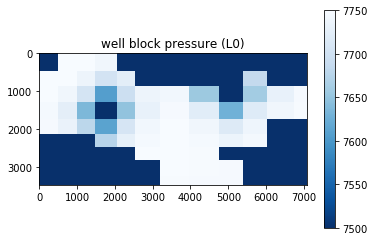

In [11]:
#Block pressure plot
import numpy as np
import matplotlib.pyplot as plt

cor = []

x_cor = 0

for ix in range (0,Nx):
    if ix == 0:
        x_cor += dx[iz,0,ix]/2    
    else:
        x_cor += dx[iz,0,ix-1]/2 + dx[iz,0,ix]/2
    y_cor = 0
    for iy in range (0,Ny):
        if iy == 0:
            y_cor += dy[iz,iy,0]/2  
            cor.append([x_cor,y_cor])
        else:
            y_cor += dy[iz,iy,0]/2 + dy[iz,iy-1,0]/2
            cor.append([x_cor,y_cor])
                
    
cor_array = np.array(cor)

pressure_L0 = []
# pressure_L1 = []
# pressure_L2 = []

for ix in range (0,Nx):
    for iy in range (0,Ny):
        pressure_L0.append(p_new[0,iy,ix])
#         pressure_L1.append(p_new[1,iy,ix])
#         pressure_L2.append(p_new[2,iy,ix])

pressure_array_L0 = np.array(pressure_L0)
# pressure_array_L1 = np.array(pressure_L1)
# pressure_array_L2 = np.array(pressure_L2)

grid_x, grid_y = np.mgrid[0:x_cor:100j, 0:y_cor:100j]

vmin_lower_limit = 7500
vmin_upper_limit = 7750


from scipy.interpolate import griddata
cmap = 'Blues_r'
grid_z0 = griddata(cor_array, pressure_array_L0, (grid_x, grid_y), method='nearest')

plt.imshow(grid_z0.T, extent=(0,x_cor,y_cor,0),vmin=vmin_lower_limit, vmax=vmin_upper_limit,cmap=cmap)
plt.title('well block pressure (L0)')
plt.colorbar()
plt.show()


# grid_z0 = griddata(cor_array, pressure_array_L1, (grid_x, grid_y), method='nearest')

# plt.imshow(grid_z0.T, extent=(0,x_cor,y_cor,0),vmin=vmin_lower_limit, vmax=vmin_upper_limit,cmap=cmap)
# plt.title('well block pressure (L1)')
# plt.colorbar()
# plt.show()


# grid_z0 = griddata(cor_array, pressure_array_L2, (grid_x, grid_y), method='nearest')

# plt.imshow(grid_z0.T, extent=(0,x_cor,y_cor,0),vmin=vmin_lower_limit, vmax=vmin_upper_limit,cmap=cmap)
# plt.title('well block pressure (L2)')
# plt.colorbar()
# plt.colorbar
# plt.show()

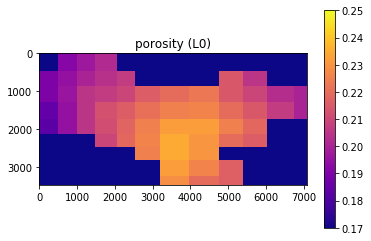

In [12]:
#Porosity map plot
import numpy as np
import matplotlib.pyplot as plt

cor = []

x_cor = 0

for ix in range (0,Nx):
    if ix == 0:
        x_cor += dx[iz,0,ix]/2    
    else:
        x_cor += dx[iz,0,ix-1]/2 + dx[iz,0,ix]/2
    y_cor = 0
    for iy in range (0,Ny):
        if iy == 0:
            y_cor += dy[iz,iy,0]/2  
            cor.append([x_cor,y_cor])
        else:
            y_cor += dy[iz,iy,0]/2 + dy[iz,iy-1,0]/2
            cor.append([x_cor,y_cor])
                
    
cor_array = np.array(cor)

porosity_L0 = []
# porosity_L1 = []
# porosity_L2 = []

for ix in range (0,Nx):
    for iy in range (0,Ny):
        porosity_L0.append(phi[0,iy,ix])
#         porosity_L1.append(phi[1,iy,ix])
#         porosity_L2.append(phi[2,iy,ix])

porosity_array_L0 = np.array(porosity_L0)
# porosity_array_L1 = np.array(porosity_L1)
# porosity_array_L2 = np.array(porosity_L2)

grid_x, grid_y = np.mgrid[0:x_cor:100j, 0:y_cor:100j]

vmin_lower_limit = 0.17
vmin_upper_limit = 0.25

from scipy.interpolate import griddata
grid_z0 = griddata(cor_array, porosity_array_L0, (grid_x, grid_y), method='nearest')

cmap = 'plasma'

plt.imshow(grid_z0.T, extent=(0,x_cor,y_cor,0),vmin=vmin_lower_limit, vmax=vmin_upper_limit,cmap=cmap)
plt.title('porosity (L0)')
plt.colorbar()
plt.show()

# grid_z0 = griddata(cor_array, porosity_array_L1, (grid_x, grid_y), method='nearest')


# plt.imshow(grid_z0.T, extent=(0,x_cor,y_cor,0),vmin=vmin_lower_limit, vmax=vmin_upper_limit,cmap=cmap)
# plt.title('porosity (L1)')
# plt.colorbar()
# plt.show()

# grid_z0 = griddata(cor_array, porosity_array_L2, (grid_x, grid_y), method='nearest')


# plt.imshow(grid_z0.T, extent=(0,x_cor,y_cor,0),vmin=vmin_lower_limit, vmax=vmin_upper_limit,cmap=cmap)
# plt.title('porosity (L2)')
# plt.colorbar()
# plt.show()

C:\Users\Kittipong Limchuchua\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: UserWarning: Z contains NaN values. This may result in rendering artifacts.


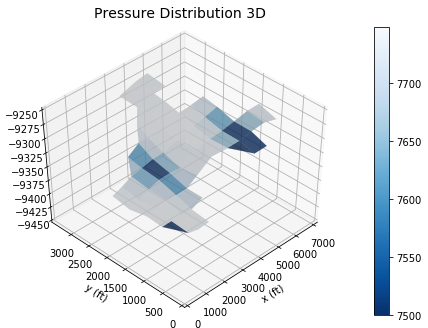

In [13]:
#Pressure Distribution (3D Map)

%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

x_array = []
y_array = []
z_array = []

iz = 0

x_cor = 0
for ix in range (0,Nx):
    if ix == 0:
        x_cor += dx[iz,0,ix]/2 
        x_array.append(x_cor)
    else:
        x_cor += dx[iz,0,ix-1]/2 + dx[iz,0,ix]/2
        x_array.append(x_cor)

y_cor = 0
for iy in range (0,Ny):
    if iy == 0:
        y_cor += dy[iz,iy,0]/2  
        y_array.append(y_cor)
    else:
        y_cor += dy[iz,iy,0]/2 + dy[iz,iy-1,0]/2
        y_array.append(y_cor)


for ix in range (0,Nx):
    for iy in range (0,Ny):
        z_array.append(middle[iz,iy,ix])


X, Y = np.meshgrid(x_array, y_array)
Z0 = -middle[iz,:,:]
pressure = p_new
Z0[abs(Z0)<1] = np.nan
    
# #Add
# Z1 = -middle[1,:,:]
# pressure = p_new
# Z1[abs(Z1)<1] = np.nan

# #Add
# Z2 = -middle[2,:,:]
# pressure = p_new
# Z2[abs(Z2)<1] = np.nan
    
fig = plt.figure()

ax = Axes3D(fig)
#ax = fig.add_subplot(111, projection='3d')
ax.view_init(45,45)
ax.set_xlim3d(abs(np.max(X)),0)
ax.set_ylim3d(abs(np.max(Y)),0)
ax.set_zlim3d(-9450,-9250)
# here we create the surface plot, but pass V through a colormap
# to create a different color for each patch
norm = matplotlib.colors.Normalize(vmin=7500, vmax=7750)
ax.plot_surface(X, Y, Z0, facecolors = cm.Blues_r(norm(pressure[iz,:,:])),linewidth=0.1,alpha = 0.8)
# ax.plot_surface(X, Y, Z1, facecolors = cm.Blues_r(norm(pressure[1,:,:])),linewidth=0.1,alpha = 0.8)
# ax.plot_surface(X, Y, Z2, facecolors = cm.Blues_r(norm(pressure[2,:,:])),linewidth=0.1,alpha = 0.8)
#fig.colorbar(fig,shrink=0.5, aspect=5)

plt.title('Pressure Distribution 3D',fontsize='14', y=1.1)
plt.xlabel('x (ft)')
plt.ylabel('y (ft)')

pressure_range = np.arange(7500,7750)
m = cm.ScalarMappable(cmap=cm.Blues_r)
m.set_array(pressure_range)
plt.colorbar(m)

C:\Users\Kittipong Limchuchua\Anaconda3\lib\site-packages\ipykernel_launcher.py:67: UserWarning: Z contains NaN values. This may result in rendering artifacts.


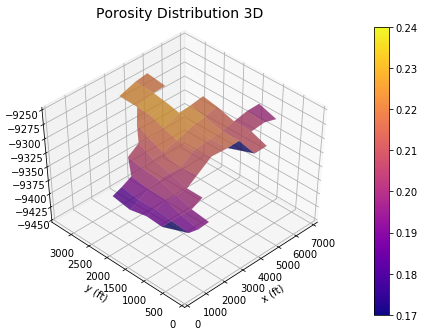

In [14]:
#Porosity Distribution (3D Map)

%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

x_array = []
y_array = []
z_array = []

iz = 0

x_cor = 0
for ix in range (0,Nx):
    if ix == 0:
        x_cor += dx[iz,0,ix]/2 
        x_array.append(x_cor)
    else:
        x_cor += dx[iz,0,ix-1]/2 + dx[iz,0,ix]/2
        x_array.append(x_cor)

y_cor = 0
for iy in range (0,Ny):
    if iy == 0:
        y_cor += dy[iz,iy,0]/2  
        y_array.append(y_cor)
    else:
        y_cor += dy[iz,iy,0]/2 + dy[iz,iy-1,0]/2
        y_array.append(y_cor)


for ix in range (0,Nx):
    for iy in range (0,Ny):
        z_array.append(middle[iz,iy,ix])


X, Y = np.meshgrid(x_array, y_array)
Z0 = -middle[iz,:,:]
pressure = p_new
Z0[abs(Z0)<1] = np.nan
    
# #Add
# Z1 = -middle[1,:,:]
# pressure = p_new
# Z1[abs(Z1)<1] = np.nan

# #Add
# Z2 = -middle[2,:,:]
# pressure = p_new
# Z2[abs(Z2)<1] = np.nan
    
fig = plt.figure()

ax = Axes3D(fig)
#ax = fig.add_subplot(111, projection='3d')
ax.view_init(45,45)
ax.set_xlim3d(abs(np.max(X)),0)
ax.set_ylim3d(abs(np.max(Y)),0)
ax.set_zlim3d(-9450,-9250)
# here we create the surface plot, but pass V through a colormap
# to create a different color for each patch
norm = matplotlib.colors.Normalize(vmin=0.17, vmax=0.25)

ax.plot_surface(X, Y, Z0, facecolors = cm.plasma(norm(phi[iz,:,:])),linewidth=0.1,alpha = 0.8)
# ax.plot_surface(X, Y, Z1, facecolors = cm.plasma(norm(phi[1,:,:])),linewidth=0.1,alpha = 0.8)
# ax.plot_surface(X, Y, Z2, facecolors = cm.plasma(norm(phi[2,:,:])),linewidth=0.1,alpha = 0.8)
#fig.colorbar(fig,shrink=0.5, aspect=5)
plt.title('Porosity Distribution 3D',fontsize='14', y=1.1)
plt.xlabel('x (ft)')
plt.ylabel('y (ft)')

porosity_range = np.arange(0.17,0.25,0.01)
m = cm.ScalarMappable(cmap=cm.plasma)
m.set_array(porosity_range)
plt.colorbar(m)

In [15]:
#for testing purpose
R_matrix = np.zeros((Nz,Ny,Nx))
for iz in range (0,Nz):
    for iy in range (0,Ny):
        for ix in range (0,Nx):
            R_matrix[iz,iy,ix] = R(iz,iy,ix,'0')
        
R_matrixW = np.zeros((Nz,Ny,Nx))
for iz in range (0,Nz):
    for iy in range (0,Ny):
        for ix in range (0,Nx):
            R_matrixW[iz,iy,ix] = R(iz,iy,ix,'W')
        
#print(R_matrix)
#print(R_matrixW)

C:\Users\Kittipong Limchuchua\Anaconda3\lib\site-packages\ipykernel_launcher.py:77: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\Kittipong Limchuchua\Anaconda3\lib\site-packages\ipykernel_launcher.py:74: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\Kittipong Limchuchua\Anaconda3\lib\site-packages\ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Kittipong Limchuchua\Anaconda3\lib\site-packages\ipykernel_launcher.py:36: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\Kittipong Limchuchua\Anaconda3\lib\site-packages\ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\Kittipong Limchuchua\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\Kittipong Limchuchua\Anaconda3\lib\site-packages\ipykernel_launcher.py:99: RuntimeWarning: divide by zero encountered in 

In [16]:
#for testing purpose
dRdp_matrixC = np.zeros((Nz,Ny,Nx))
for iz in range (0,Nz):
    for iy in range (0,Ny):
        for ix in range (0,Nx):
            dRdp_matrixC[iz,iy,ix] = dR_dp(iz,iy,ix,'C')
#print(dRdp_matrixC)

dRdp_matrixW = np.zeros((Nz,Ny,Nx))
for iz in range (0,Nz):
    for iy in range (0,Ny):
        for ix in range (0,Nx):
            dRdp_matrixW[iz,iy,ix] = dR_dp(iz,iy,ix,'W')
#print(dRdp_matrixW)

C:\Users\Kittipong Limchuchua\Anaconda3\lib\site-packages\ipykernel_launcher.py:77: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\Kittipong Limchuchua\Anaconda3\lib\site-packages\ipykernel_launcher.py:74: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\Kittipong Limchuchua\Anaconda3\lib\site-packages\ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Kittipong Limchuchua\Anaconda3\lib\site-packages\ipykernel_launcher.py:36: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\Kittipong Limchuchua\Anaconda3\lib\site-packages\ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\Kittipong Limchuchua\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\Kittipong Limchuchua\Anaconda3\lib\site-packages\ipykernel_launcher.py:99: RuntimeWarning: divide by zero encountered in 

In [17]:
#print(residual_dp)